# 1. Marchenko-Pastur distribution

### (I) MP's Distribution as applied on the Spiked Model


In [8]:
import numpy as np
import pandas as pd


def generate_spiked_covariance_vectors(n, p, sigma):
    """
    Generate n random vectors of dimension p according to the spiked covariance model.

    Parameters:
    n (int): Number of vectors to generate.
    p (int): Dimension of each vector.
    sigma (float): Scaling factor for the Gaussian noise.

    Returns:
    np.ndarray: An array of shape (n, p) containing the generated vectors.
    """
    # Fixed vector v with norm 1
    v = np.random.randn(p)
    v /= np.linalg.norm(v)

    # Initialize an array to store the vectors
    vectors = np.zeros((n, p))

    for i in range(n):
        # Generate a_i from the standard normal distribution
        a_i = np.random.randn()

        # Generate a standard random multivariate Gaussian vector
        xi = np.random.randn(p)

        # Compute the spiked covariance model vector
        vectors[i] = a_i * v + sigma * xi

    return vectors

n = 300  # Number of vectors
p = 50   # Dimension of each vector
sigma = 1.0  # Scaling factor for Gaussian noise

vectors = generate_spiked_covariance_vectors(n, p, sigma)
# relinquish


In [9]:
import numpy as np
import matplotlib.pyplot as plt

def generate_spiked_data(n, p, spikes):
    """
    Generate random vectors according to the spiked covariance model.

    Parameters:
    n (int): Number of samples.
    p (int): Dimension of each sample.
    spikes (list): Positions in the covariance matrix to spike.

    Returns:
    np.ndarray: Generated data of shape (n, p).
    """
    # Base covariance matrix (identity for simplicity)
    covariance_matrix = np.eye(p) # identity matrix of size p

    # Introducing spikes
    for spike in spikes:
        covariance_matrix[spike, spike] *= 10  # Increasing the variance

    # Generate random vectors using multivariate normal distribution
    mean_vector = np.zeros(p)
    data = np.random.multivariate_normal(mean_vector, covariance_matrix, n)

    return data

# Parameters
n = 300  # Number of vectors
p = 50    # Dimension of each vector
spikes = [0, 1, 2]  # Spiking first three dimensions
spikes = [1]  # Spiking first three dimensions

# Generate data
data = generate_spiked_data(n, p, spikes)


In [10]:
import numpy as np
import matplotlib.pyplot as plt

def generate_spiked_covariance_vectors(n, p, sigma):
    # Fixed vector v with norm 1
    v = np.random.randn(p)
    v /= np.linalg.norm(v) # normalize v
    

    # Initialize an array to store the vectors of shape (rows = n, cols = p)
    vectors = np.zeros((n, p))

    for i in range(n):
        # Generate a_i from the standard normal distribution
        a_i = np.random.randn()
        # print("a_i:",a_i)
        # Generate a standard random multivariate Gaussian vector
        xi = np.random.randn(p)
        # print("a_i:",xi)
        # Compute the spiked covariance model vector, which is the sum of two vectors scaled by a random a_i and a given sigma
        vectors[i] = a_i * v + sigma * xi
        # print(f"vectors[i={i}]:", vectors[i])
    return vectors

# Parameters
n = 300 # samples
p = 50 # features
sigma = 1 # scaling factor for Gaussian noise

# Generate vectors
vectors = generate_spiked_covariance_vectors(n, p, sigma)
print(f"Random vectors:\nShape:{vectors.shape}\n{vectors}")


Random vectors:
Shape:(300, 50)
[[-0.23863474  0.17455769  0.7096632  ...  1.34603416 -1.42280662
  -1.67765384]
 [ 1.91640705 -0.53961503 -1.40120374 ... -1.06456437 -0.10494765
   1.07892546]
 [ 0.86091991  1.86751244  0.48344259 ...  0.05093169  0.1776553
  -0.31617463]
 ...
 [ 0.38048271 -1.44906761 -0.87868496 ... -1.06745088 -0.80827678
  -0.53872913]
 [-2.24517698 -0.95635224  0.15621305 ...  0.67049223  0.5989716
   0.70841706]
 [ 0.81890481  0.17352485 -0.19506077 ...  0.28060315 -0.09887156
   0.11837065]]


In [11]:
# compute the covariance directly
R = np.dot(vectors.T, vectors) / (n)
print(f"Covariance matrix R:\nShape: {R.shape}\nValues:",R)


Covariance matrix R:
Shape: (50, 50)
Values: [[ 0.95987927  0.041279    0.04722835 ... -0.01108331  0.04192057
  -0.06878403]
 [ 0.041279    1.04427881  0.00818919 ...  0.03028091  0.11936241
   0.02505146]
 [ 0.04722835  0.00818919  0.85824826 ... -0.01004277 -0.0501861
  -0.02868555]
 ...
 [-0.01108331  0.03028091 -0.01004277 ...  1.02029686  0.07452445
   0.0675299 ]
 [ 0.04192057  0.11936241 -0.0501861  ...  0.07452445  1.07882461
  -0.01045425]
 [-0.06878403  0.02505146 -0.02868555 ...  0.0675299  -0.01045425
   1.00204426]]


In [12]:
import pandas as pd

def mpPDF(var, q, pts):
    """
    Creates a Marchenko-Pastur Probability Density Function
    Args:
        var (float): Variance
        q (float): T/N where T is the number of rows and N the number of columns
        pts (int): Number of points used to construct the PDF
    Returns:
        pd.Series: Marchenko-Pastur PDF
    """
    # Marchenko-Pastur pdf
    # q=T/N
    # Adjusting code to work with 1 dimension arrays
    if isinstance(var, np.ndarray):
        if var.shape == (1,):
            var = var[0]
    eMin, eMax = var * (1 - (1. / q) ** .5) ** 2, var * (1 + (1. / q) ** .5) ** 2
    eVal = np.linspace(eMin, eMax, pts)
    pdf = q / (2 * np.pi * var * eVal) * ((eMax - eVal) * (eVal - eMin)) ** .5
    pdf = pd.Series(pdf, index=eVal)
    return pdf


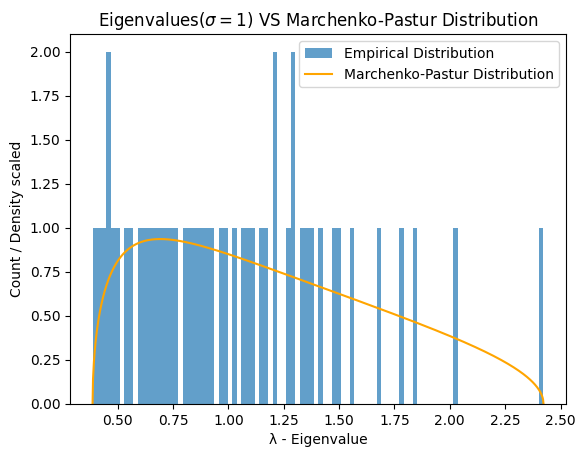

In [13]:
# Extract the Eigenvalues of R
eigenvalues, _ = np.linalg.eigh(R)

lambda_range = np.linspace(eigenvalues.min(), eigenvalues.max(), 1000)

# Calculate the MP distribution
mp_distribution = mpPDF(1., q=vectors.shape[0]/float(vectors.shape[1]), pts=1000)
# Plot the histogram and the MP distribution
plt.hist(eigenvalues, bins=100, density=False,  alpha=0.7, label='Empirical Distribution')
plt.plot(lambda_range, mp_distribution, color='orange', label='Marchenko-Pastur Distribution')
plt.title("Eigenvalues($\sigma=1$) VS Marchenko-Pastur Distribution")
plt.xlabel("λ - Eigenvalue")
plt.ylabel("Count / Density scaled")
plt.legend()
plt.show()


It can be seen that under the sigma value equal to 1, when the true value is distributed like the noise, that is, without a significant spike, the distribution of the eigenvalues corresponds to the Marchenko-Pastur distribution.

The meaning of this is that it was not possible to extract highly significant eigenvalues for the investigation of the tested variable.

### (II) MP's Distribution and the Spiked Model with $\sigma \isin \{0.2,0.4,..,1.8,2\} $


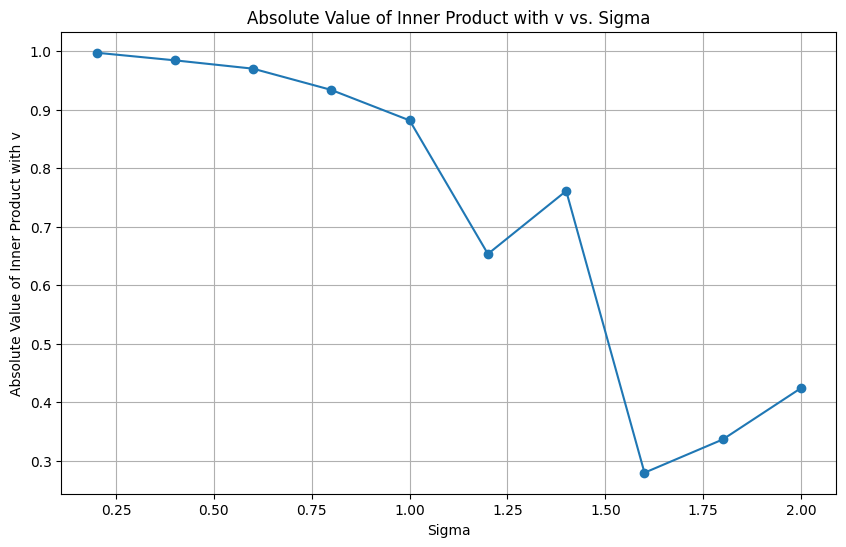

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Fixed vector v with norm 1
v = np.random.randn(p)
v /= np.linalg.norm(v)

def generate_spiked_covariance_vectors(n, p, sigma, v):
    """
    Generate n random vectors of dimension p according to the spiked covariance model.

    Parameters:
    n (int): Number of vectors to generate.
    p (int): Dimension of each vector.
    sigma (float): Scaling factor for the Gaussian noise.
    v (np.ndarray): Fixed vector with norm 1 used in the spiked model.

    Returns:
    np.ndarray: An array of shape (n, p) containing the generated vectors.
    """
    vectors = np.zeros((n, p))

    for i in range(n):
        a_i = np.random.randn()
        xi = np.random.randn(p)
        vectors[i] = a_i * v + sigma * xi

    return vectors

def compute_leading_eigenvector_inner_product(n, p, sigma, v):
    """
    Generate random vectors according to the spiked covariance model, compute the covariance matrix R,
    find its leading eigenvector, and compute the absolute value of its inner product with v.

    Parameters:
    n (int): Number of vectors.
    p (int): Dimension of vectors.
    sigma (float): Standard deviation used in the spiked covariance model.
    v (np.ndarray): Fixed vector with norm 1.

    Returns:
    float: The absolute value of the inner product between v and the leading eigenvector of R.
    """
    # Generate random vectors according to the spiked covariance model
    vectors = generate_spiked_covariance_vectors(n, p, sigma, v)

    # Compute the covariance matrix R
    R = np.cov(vectors.T)

    # Compute the eigenvalues and eigenvectors of R
    eigenvalues, eigenvectors = np.linalg.eigh(R)

    # Extract the leading eigenvector
    leading_eigenvector = eigenvectors[:, -1]

    # Compute the absolute value of the inner product with v
    return np.abs(np.inner(leading_eigenvector, v))

# Parameters
n = 300
p = 50
s_values = np.arange(0.2, 2.2, 0.2)  # Sigma values from 0.2 to 2.0

# Compute the inner products for each sigma
inner_products = [compute_leading_eigenvector_inner_product(n, p, s, v) for s in s_values]

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(s_values, inner_products, marker='o')
plt.title('Absolute Value of Inner Product with v vs. Sigma')
plt.xlabel('Sigma')
plt.ylabel('Absolute Value of Inner Product with v')
plt.grid(True)
plt.show()


#### When does the result start to degrade?
The more the subspace of the eigenvector corresponding to the maximum eigenvalue differs from the space of the random noise, the closer it gets to orthogonality with the noise vector. Hence, the inner product of that eigenvector with the noise vector will approach 0. The meaning of the above is that the more the eigenvector represents an information space that is different from the random noise, the more it represents an inherent feature that is more informative for us in the data analysis.

# 2. WHO's YOUR DATA?

# 3 Kernel PCA to Non-Linearly Distributed Data

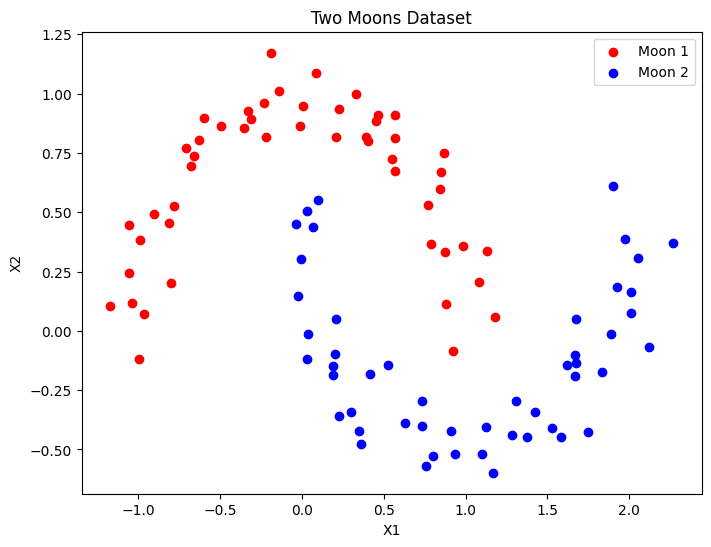

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

# Generate the two moons dataset
X_moons, y_moons = make_moons(n_samples=100, noise=0.1, random_state=42)

# Plotting the two moons dataset
plt.figure(figsize=(8, 6))
plt.scatter(X_moons[y_moons == 0][:, 0], X_moons[y_moons == 0][:, 1], color='red', label='Moon 1')
plt.scatter(X_moons[y_moons == 1][:, 0], X_moons[y_moons == 1][:, 1], color='blue', label='Moon 2')
plt.title("Two Moons Dataset")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.show()


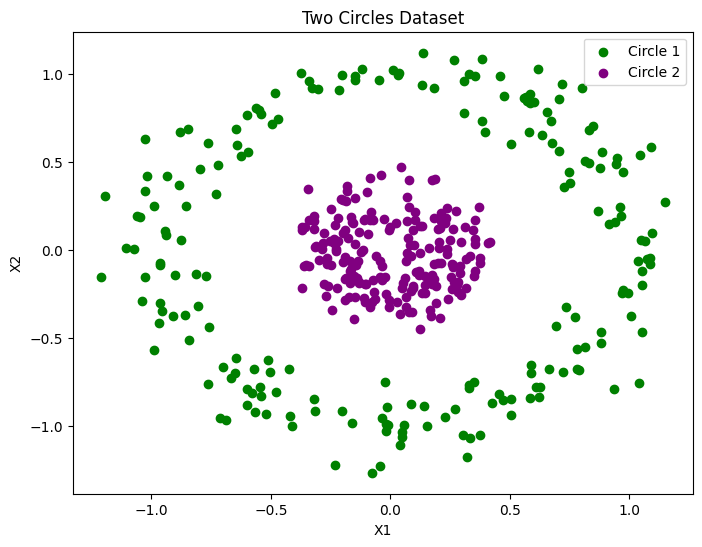

In [16]:
def generate_circle_data(radius, center, n_samples=200, noise_std=0.1):
    """
    Generate n_samples points along a circle with specified radius and center.
    Gaussian noise is added to the points.
    """
    angles = np.random.rand(n_samples) * 2 * np.pi
    x = center[0] + radius * np.cos(angles)
    y = center[1] + radius * np.sin(angles)
    noise = np.random.normal(scale=noise_std, size=(n_samples, 2))
    return np.column_stack([x, y]) + noise

# Generate two circles dataset
X_circle_large = generate_circle_data(radius=1, center=(0, 0),noise_std=0.1)
X_circle_small = generate_circle_data(radius=0.25, center=(0, 0),noise_std=0.1)
X_circles = np.vstack([X_circle_large, X_circle_small])
y_circles = np.array([0]*200 + [1]*200)  # Labels: 0 for large circle, 1 for small circle

# Plotting the two circles dataset
plt.figure(figsize=(8, 6))
plt.scatter(X_circles[y_circles == 0][:, 0], X_circles[y_circles == 0][:, 1], color='green', label='Circle 1')
plt.scatter(X_circles[y_circles == 1][:, 0], X_circles[y_circles == 1][:, 1], color='purple', label='Circle 2')
plt.title("Two Circles Dataset")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.show()


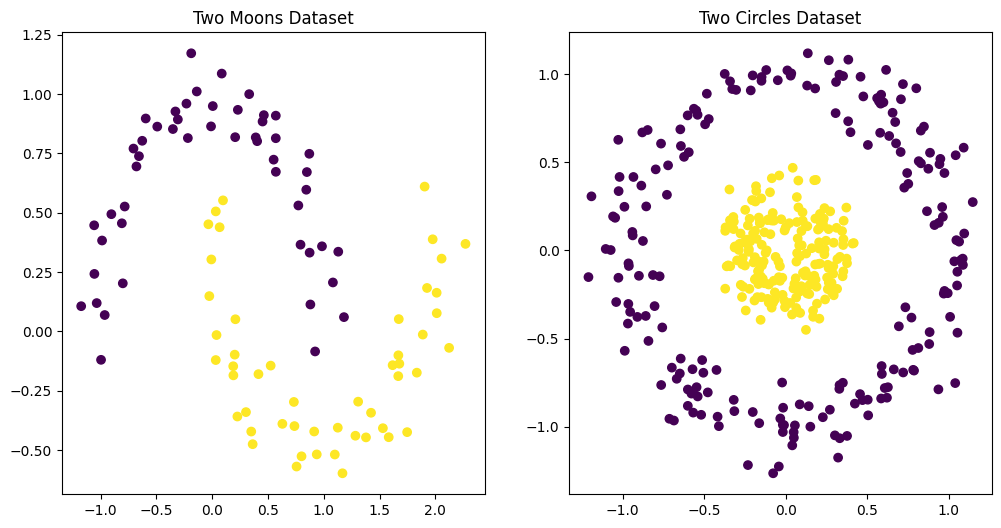

In [17]:

from sklearn.decomposition import KernelPCA

# Plotting the datasets
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Two Moons Dataset")
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons)

plt.subplot(1, 2, 2)
plt.title("Two Circles Dataset")
plt.scatter(X_circles[:, 0], X_circles[:, 1], c=y_circles)

plt.show()


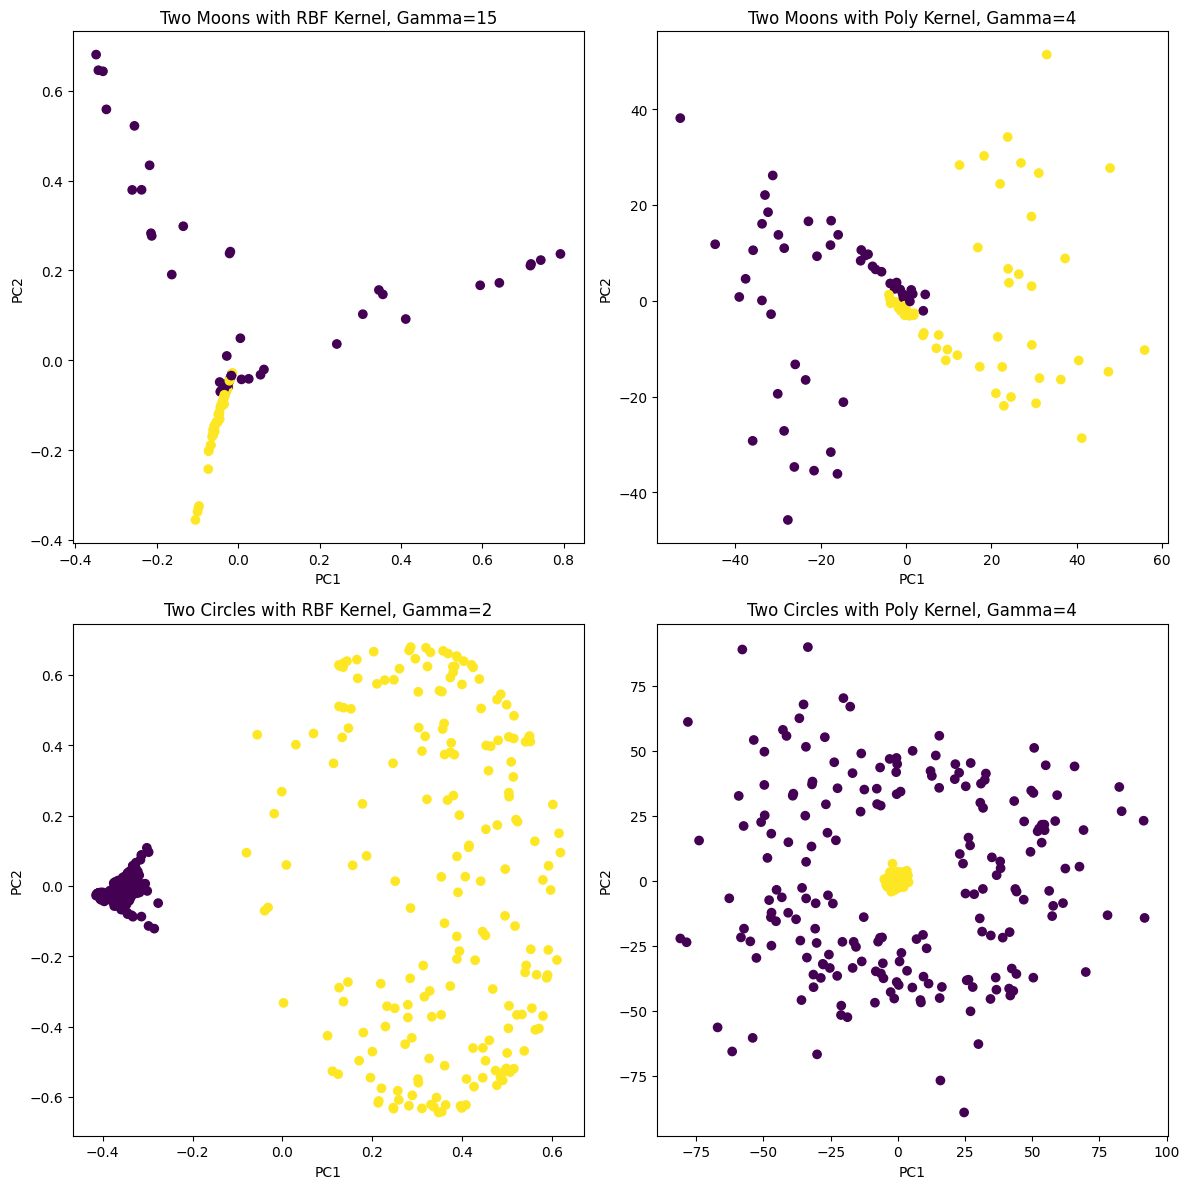

In [18]:
from sklearn.preprocessing import StandardScaler

# Function to apply Kernel PCA and plot the results
def apply_and_plot_kernel_pca(X, y, kernel, gamma, title):
    kpca = KernelPCA(kernel=kernel, gamma=gamma, n_components=2)
    X_kpca = kpca.fit_transform(X)
    plt.scatter(X_kpca[:, 0], X_kpca[:, 1], c=y)
    plt.title(title)
    plt.xlabel('PC1')
    plt.ylabel('PC2')

# Standardizing the datasets before applying Kernel PCA
scaler_moons = StandardScaler()
X_moons_std = scaler_moons.fit_transform(X_moons)

scaler_circles = StandardScaler()
X_circles_std = scaler_circles.fit_transform(X_circles)

# Applying Kernel PCA with different parameters
plt.figure(figsize=(12, 12))

# Two Moons with RBF kernel (should separate well)
plt.subplot(2, 2, 1)
apply_and_plot_kernel_pca(X_moons_std, y_moons, kernel='rbf', gamma=15, title="Two Moons with RBF Kernel, Gamma=15")

# Two Moons with Poly kernel (might not separate well)
plt.subplot(2, 2, 2)
apply_and_plot_kernel_pca(X_moons_std, y_moons, kernel='poly', gamma=4, title="Two Moons with Poly Kernel, Gamma=4")

# Two Circles with RBF kernel (should separate well)
plt.subplot(2, 2, 3)
apply_and_plot_kernel_pca(X_circles_std, y_circles, kernel='rbf', gamma=2, title="Two Circles with RBF Kernel, Gamma=2")

# Two Circles with Poly kernel (might not separate well)
plt.subplot(2, 2, 4)
apply_and_plot_kernel_pca(X_circles_std, y_circles, kernel='poly', gamma=4, title="Two Circles with Poly Kernel, Gamma=4")

plt.tight_layout()
plt.show()


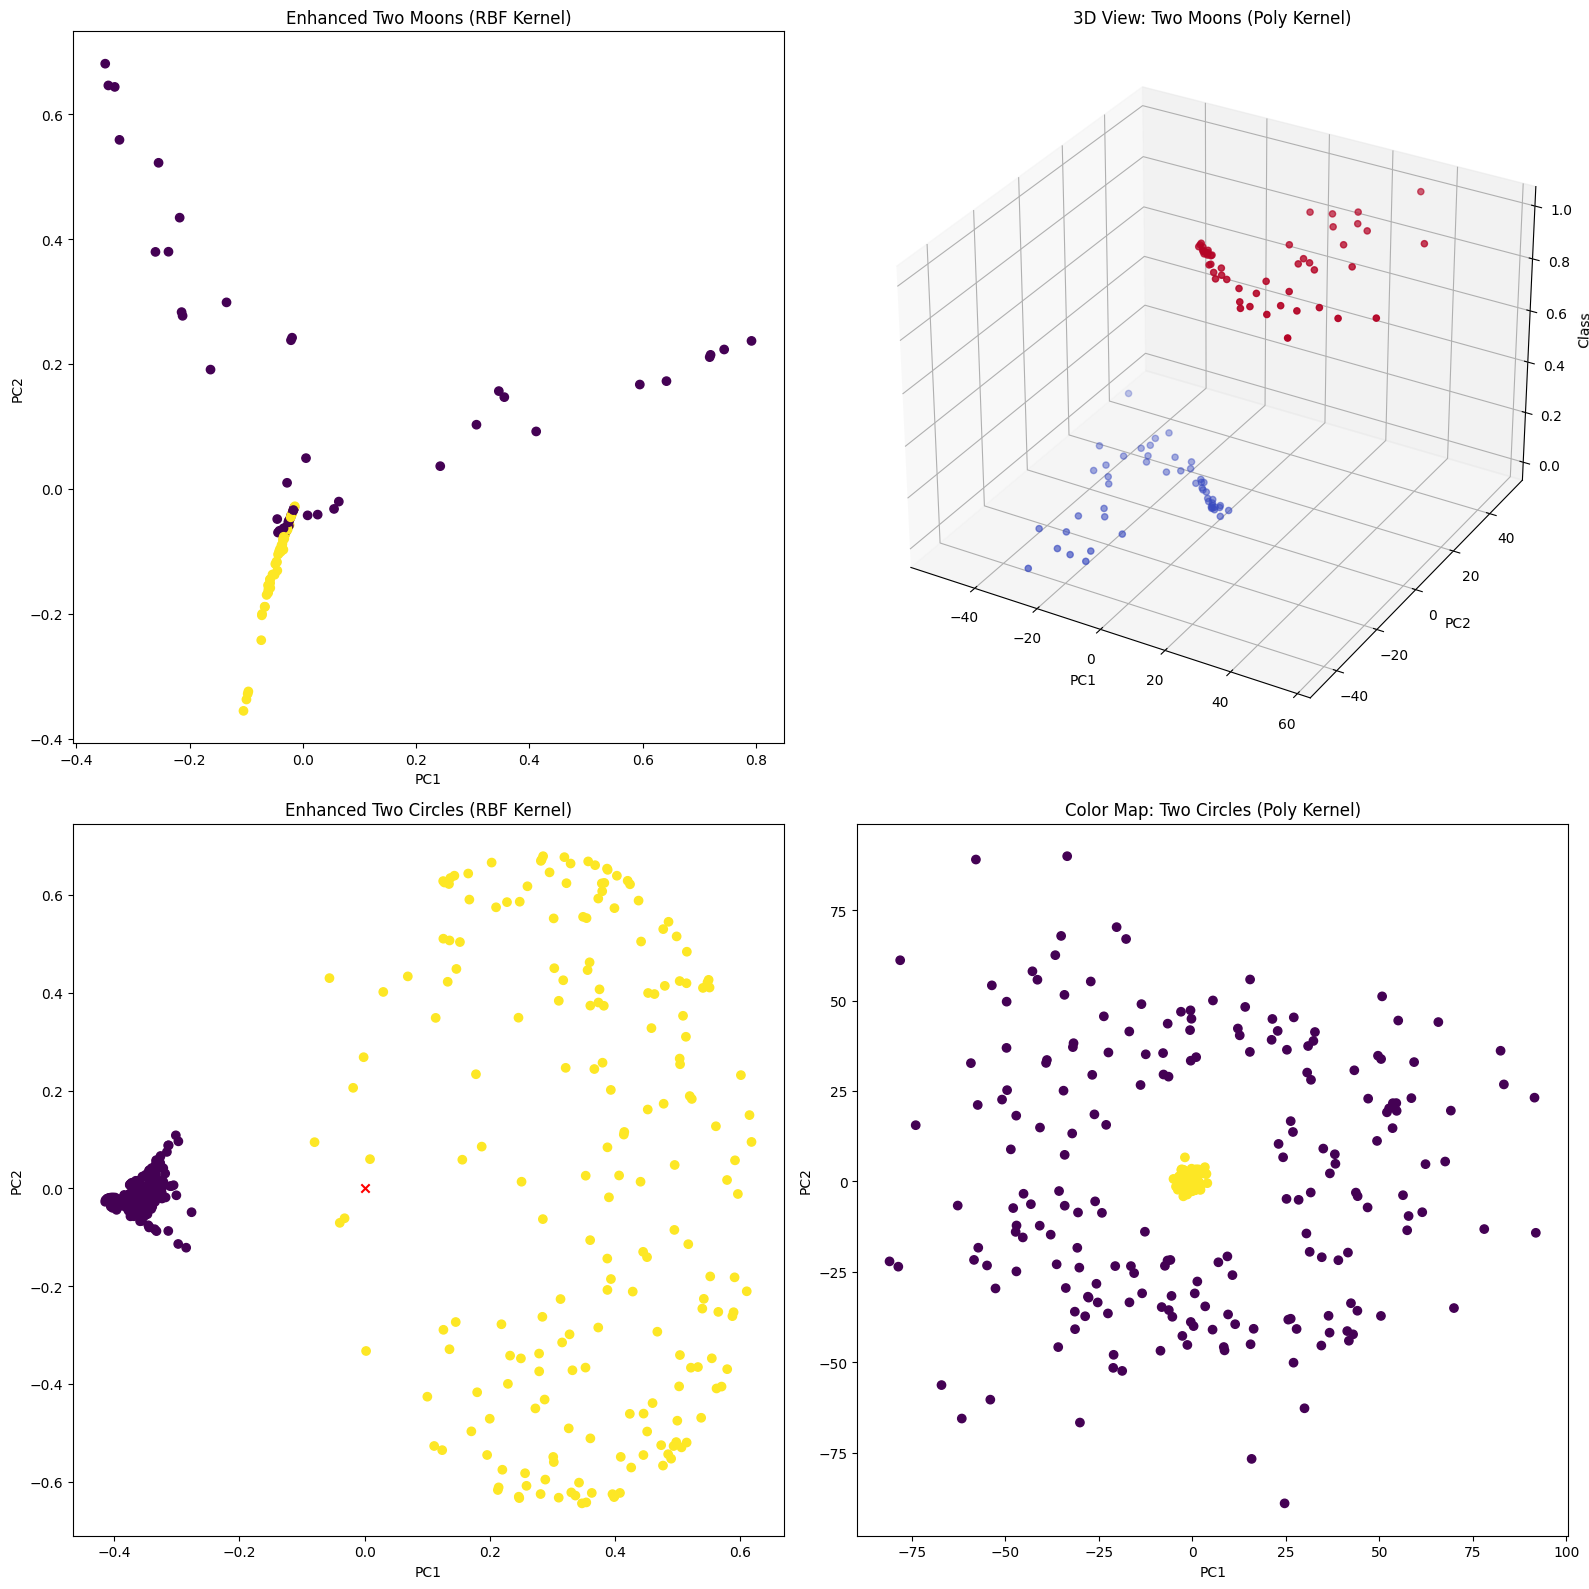

In [19]:
from mpl_toolkits.mplot3d import Axes3D

# Enhancing the visualizations with more creative elements
plt.figure(figsize=(16, 16))

# Two Moons with RBF kernel - Enhanced with different colors and annotations
plt.subplot(2, 2, 1)
apply_and_plot_kernel_pca(X_moons_std, y_moons, kernel='rbf', gamma=15, title="Enhanced Two Moons (RBF Kernel)")

# Two Moons with Poly kernel - Adding a 3D perspective
ax = plt.subplot(2, 2, 2, projection='3d')
kpca = KernelPCA(kernel='poly', gamma=4, n_components=2)
X_moons_kpca = kpca.fit_transform(X_moons_std)
ax.scatter(X_moons_kpca[:, 0], X_moons_kpca[:, 1], y_moons, c=y_moons, cmap="coolwarm")
ax.set_title("3D View: Two Moons (Poly Kernel)")
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('Class')

# Two Circles with RBF kernel - Enhanced visualization
plt.subplot(2, 2, 3)
apply_and_plot_kernel_pca(X_circles_std, y_circles, kernel='rbf', gamma=2, title="Enhanced Two Circles (RBF Kernel)")
plt.scatter(0, 0, c='red', marker='x')  # Marking the center

# Two Circles with Poly kernel - Enhanced with color map
plt.subplot(2, 2, 4)
apply_and_plot_kernel_pca(X_circles_std, y_circles, kernel='poly', gamma=4, title="Color Map: Two Circles (Poly Kernel)")

plt.tight_layout()
plt.show()
